<a href="https://colab.research.google.com/github/SakshiDesai9/DATA-SCIENCE-INTERNSHIP/blob/main/Titanic%20Survival%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Titanic Survival Prediction**

In [1]:
import pandas as pd

In [6]:
import numpy as np

In [74]:
import seaborn as sns

In [7]:
import matplotlib.pyplot as plt

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
from sklearn.pipeline import Pipeline

In [10]:
from sklearn.impute import SimpleImputer

In [11]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [12]:
from sklearn.compose import ColumnTransformer

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve
)

In [4]:
import joblib

In [27]:
df = pd.read_csv("Titanic_Dataset.csv")

In [28]:
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.')


In [29]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [30]:
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)


In [31]:
title_counts = df['Title'].value_counts()
rare_titles = title_counts[title_counts < 10].index

In [32]:
df['Title'] = df['Title'].replace(list(rare_titles), 'Rare')


In [33]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
            'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone']

In [34]:
target = 'Survived'

In [35]:
X = df[features]
y = df[target]


In [36]:
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']

In [37]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [38]:
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'IsAlone']

In [39]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [40]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [42]:
lr_pipeline = Pipeline(steps=[('pre', preprocessor),
                              ('clf', LogisticRegression(max_iter=1000))])


In [43]:
rf_pipeline = Pipeline(steps=[('pre', preprocessor),
                              ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))])


In [44]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch', 'FamilySize']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Title', 'IsAlone'])])),
                ('clf', LogisticRegression(max_iter=1000))])

In [45]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch', 'FamilySize']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Title', 'IsAlone'])])),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))])

In [46]:
def evaluate(model, X_test, y_test, name='Model'):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"=== {name} ===")
    print("Accuracy:", round(acc,4))
    if auc is not None:
        print("ROC AUC:", round(auc,4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")
    return y_pred, y_proba

In [49]:
lr_pred, lr_proba = evaluate(lr_pipeline, X_test, y_test, "Logistic Regression")


=== Logistic Regression ===
Accuracy: 0.8492
ROC AUC: 0.8783

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88       110
           1       0.83      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179

Confusion Matrix:
 [[99 11]
 [16 53]]




In [48]:
rf_pred, rf_proba = evaluate(rf_pipeline, X_test, y_test, "Random Forest")

=== Random Forest ===
Accuracy: 0.8212
ROC AUC: 0.831

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86       110
           1       0.78      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

Confusion Matrix:
 [[96 14]
 [18 51]]




In [51]:
plt.figure()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

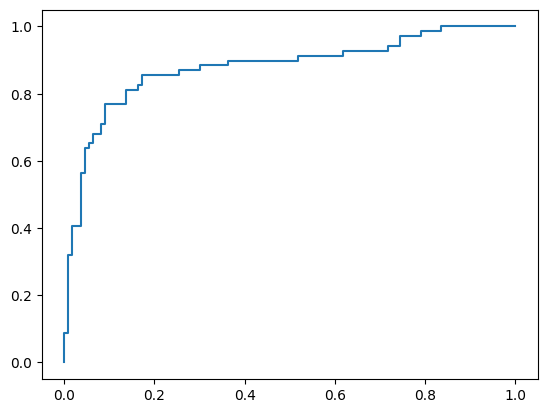

In [53]:
fpr, tpr, _ = roc_curve(y_test, lr_proba)
plt.plot(fpr, tpr, label="Logistic Regression")


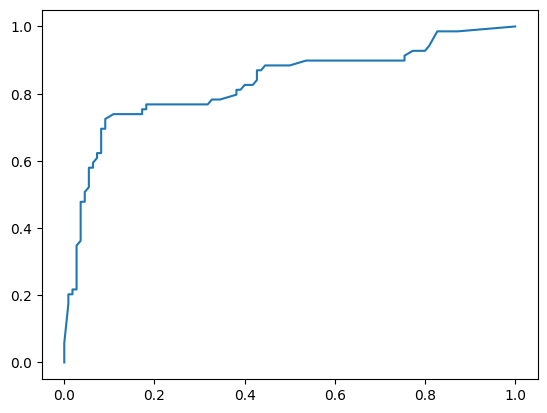

In [54]:
fpr2, tpr2, _ = roc_curve(y_test, rf_proba)
plt.plot(fpr2, tpr2, label="Random Forest")



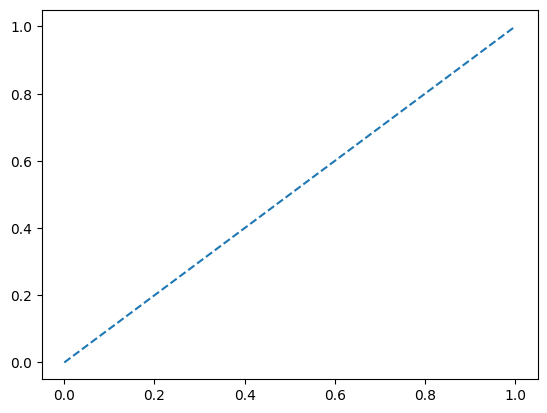

In [55]:
plt.plot([0,1],[0,1], linestyle="--")


Text(0.5, 0, 'False Positive Rate')

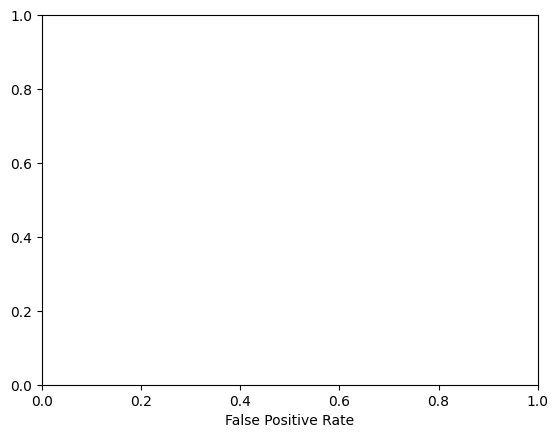

In [56]:
plt.xlabel("False Positive Rate")


Text(0, 0.5, 'True Positive Rate')

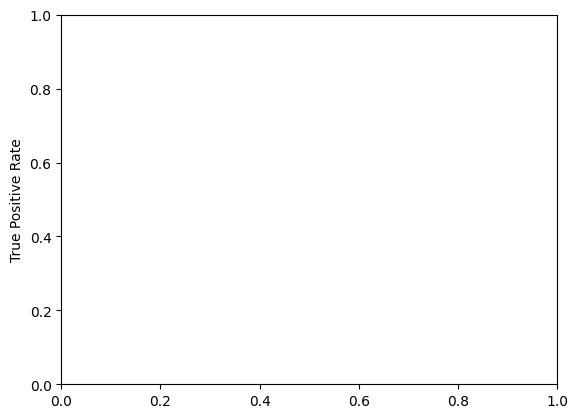

In [60]:
plt.ylabel("True Positive Rate")




Text(0.5, 1.0, 'ROC Curve')

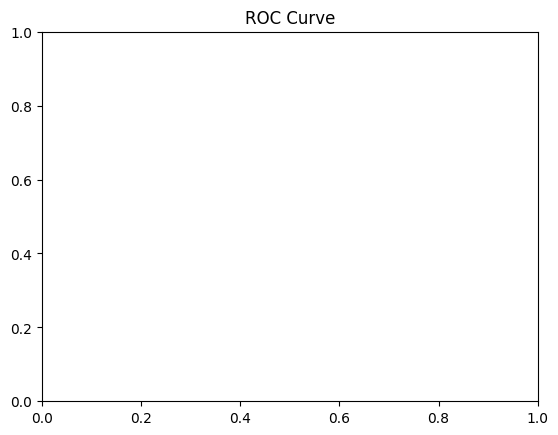

In [61]:
plt.title("ROC Curve")


/tmp/ipython-input-1453150367.py:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


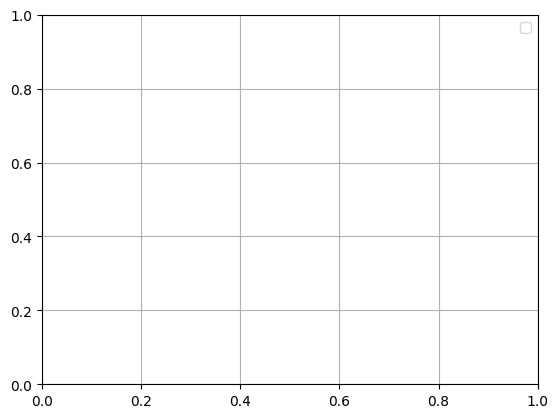

In [64]:
plt.legend()
plt.grid(True)


In [65]:
plt.show()



In [67]:
onehot_cols = list(rf_pipeline.named_steps['pre']
                   .transformers_[1][1]
                   .named_steps['onehot']
                   .get_feature_names_out(categorical_features))


In [68]:
all_features = numeric_features + onehot_cols
importances = rf_pipeline.named_steps['clf'].feature_importances_

feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

In [69]:
print("\nTop 10 feature importances:\n", feat_imp.head(10))



Top 10 feature importances:
 Fare          0.225730
Age           0.210497
Title_Mr      0.118215
Sex_female    0.085499
Sex_male      0.078465
FamilySize    0.046587
Pclass_3      0.041687
Pclass_1      0.030053
SibSp         0.028351
Parch         0.019833
dtype: float64


/tmp/ipython-input-2488780376.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=df, palette="Set2")


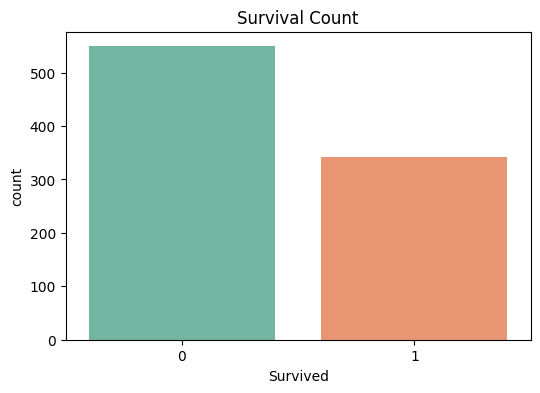

In [77]:
plt.figure(figsize=(6,4))
sns.countplot(x='Survived', data=df, palette="Set2")
plt.title("Survival Count")
plt.show()

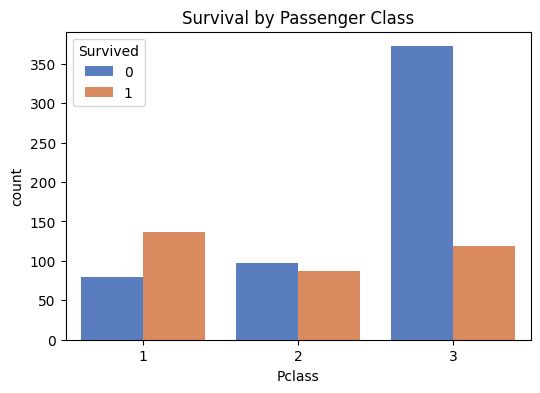

In [78]:
plt.figure(figsize=(6,4))
sns.countplot(x='Pclass', hue='Survived', data=df, palette="muted")
plt.title("Survival by Passenger Class")
plt.show()

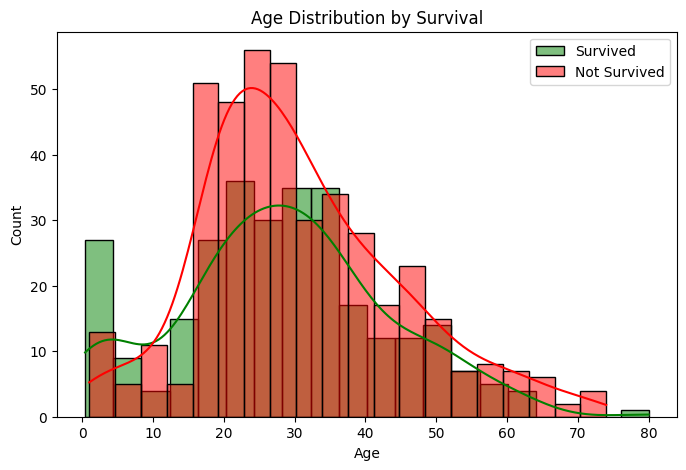

In [79]:
plt.figure(figsize=(8,5))
sns.histplot(df[df['Survived']==1]['Age'], bins=20, kde=True, color="green", label="Survived")
sns.histplot(df[df['Survived']==0]['Age'], bins=20, kde=True, color="red", label="Not Survived")
plt.title("Age Distribution by Survival")
plt.legend()
plt.show()

/tmp/ipython-input-3125303240.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Pclass", y="Fare", data=df, palette="coolwarm")


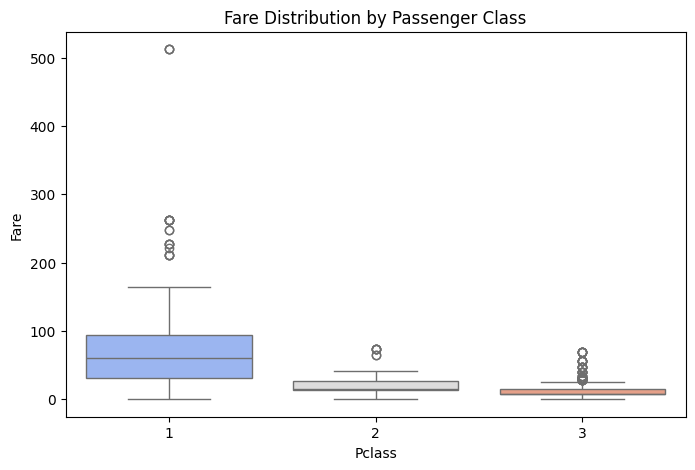

In [80]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Pclass", y="Fare", data=df, palette="coolwarm")
plt.title("Fare Distribution by Passenger Class")
plt.show()

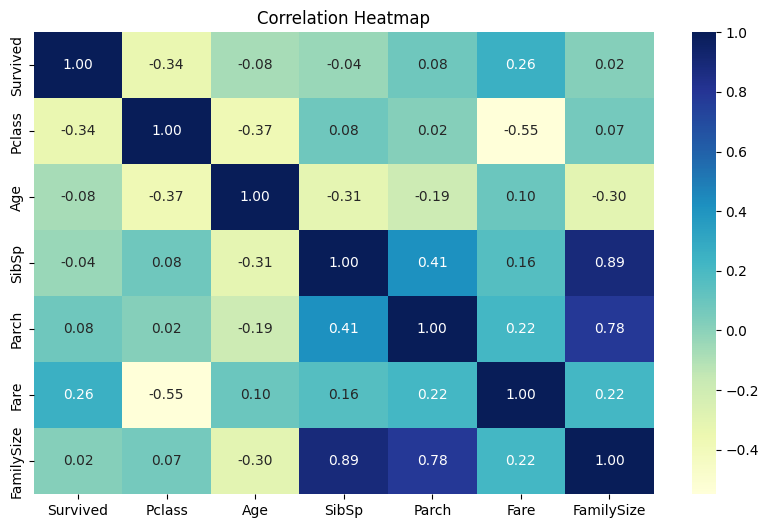

In [81]:
plt.figure(figsize=(10,6))
sns.heatmap(df[['Survived','Pclass','Age','SibSp','Parch','Fare','FamilySize']].corr(),
            annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

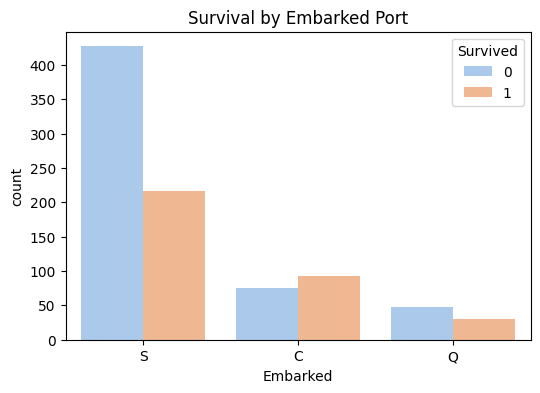

In [82]:
plt.figure(figsize=(6,4))
sns.countplot(x='Embarked', hue='Survived', data=df, palette="pastel")
plt.title("Survival by Embarked Port")
plt.show()

In [70]:
joblib.dump(lr_pipeline, "logistic_pipeline.joblib")

['logistic_pipeline.joblib']

In [71]:
joblib.dump(rf_pipeline, "rf_pipeline.joblib")

['rf_pipeline.joblib']

In [72]:
feat_imp.to_csv("feature_importances.csv", header=['importance'])